# Setup

In [6]:
%matplotlib inline
import sys
import os


os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch
from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);


In [7]:
from matplotlib import image, transforms

In [8]:
version = 13
SYNTH_DATA_PATH = '../../lesion_mri/'
BASE_LOG_PATH = 'assets/models/lesion_volume/SVIExperiment'
FIGURE_SAVE_PATH = f'figures/v{version}'

os.chdir('/ritter/share/projects/larschen/3dscm_1gpu/3dscm')
os.makedirs(FIGURE_SAVE_PATH, exist_ok=True)

In [9]:
from deepscm.experiments.lesion_volume import synth # noqa: F401
from deepscm.experiments.lesion_volume.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [10]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

In [11]:
from deepscm.datasets.lesion_data import NvidiaDataset

synth_test = NvidiaDataset(train=False)


In [12]:
var_name = {'brain_vol': 'b', 'sex': 's', 'age': 'a'}
value_fmt = {
    'ventricle_vol': lambda s: rf'{float(s):.4g}\,\mathrm{{ml}}',
    'brain_vol': lambda s: rf'{float(s):.4g}\,\mathrm{{ml}}',
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
        return f"$do({all_interventions})$"

In [13]:
def prep_data(batch):
    x = batch['image'].unsqueeze(0)
    age = batch['age'].unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].unsqueeze(0).unsqueeze(0).float()
    score = batch['score'].unsqueeze(0).unsqueeze(0).float()
    brain_vol = batch['brain_vol'].unsqueeze(0).unsqueeze(0).float()
    ventricle_vol = batch['ventricle_vol'].unsqueeze(0).unsqueeze(0).float()
    lesion_vol = batch['lesion_vol'].unsqueeze(0).unsqueeze(0).float()


    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'score':score, 'ventricle_vol': ventricle_vol, 'brain_vol': brain_vol, 'lesion_vol':lesion_vol}

## Metrics

In [14]:
columns = [
    'exp', 'loss', 'log p(x)', 'log p(age)', 'log p(sex)', 'log p(ventricle_vol)', 'log p(lesion_vol)', 'log p(score)',
    'log p(brain_vol)', 'log p(z) - log q(z)', 'p(z)', 'q(z)'
]
metrics_df = pd.DataFrame(columns=columns)
experiments = ['ConditionalVISEM']

In [15]:
for exp in experiments:
    try:
        print(exp)
        metrics = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/metrics.pt')
        for k, v in metrics.items():
            print(f'{k}: {v:.0f}')
        row = {k.replace('test/', ''): np.array(v) for k, v in metrics.items()}
        metrics_df.loc[len(metrics_df)] = {'exp': exp, **row}
    except:
        pass

ConditionalVISEM
test/loss: 10235815941
test/log p(x): -665461440
test/log p(age): -6
test/log p(sex): -1
test/log p(ventricle_volume): -5
test/log p(brain_volume): -6
test/log p(lesion_volume): -7
test/p(z): -682
test/q(z): 1346
test/log p(z) - log q(z): -2028


In [16]:
recon_mae = {}
for exp in experiments:
    try:
        reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')
        diff = []
        for i in trange(reconstructions['x'].shape[0]-1): # lpc
            diff += [reconstructions['x'][i] - (synth_test[i]['image'] * 255.)]
        recon_mae[exp] = np.mean(np.abs(torch.stack(diff).numpy()))
    except Exception as e:
        print(e)
    
metrics_df.loc[:, 'recon_mae'] = list(recon_mae.values())

  1%|          | 2/199 [00:00<00:45,  4.32it/s]


invalid literal for int() with base 10: ''


ValueError: Length of values (0) does not match length of index (1)

# Loaded Models

In [27]:
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{version}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hyper_parameters']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

In [28]:
import scipy.misc
from scipy import ndimage

# Dataset Samples

In [29]:
np.array([])

array([], dtype=float64)

In [30]:
synth_test[2]['centers']

ValueError: invalid literal for int() with base 10: ''

In [33]:
slice = 'axial' # axial sagittal coronal, 

num_cols = 3
num_rows = 2
num = num_cols * num_rows

fig = plt.figure(figsize=(num_cols * 0.8, num_rows * 0.8))

save_name = 'synthetic_samples'
degrees = 180

for i in range(num):
    idx = np.random.randint(0,20)
    d = synth_test[idx]['image']
    les_centers = synth_test[idx]['centers']
    if len(les_centers) == 0:
        slice = [32,48,37]
    else:
        slice = les_centers[0]
    img = ndimage.rotate(d.squeeze(), degrees)
    
    shape = img.shape
    if slice == 'axial':
        gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.6, hspace=0.01)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[:,:,slice[2]], 270), img_cm, vmin=0, vmax=255)
    elif slice == 'sagittal':
        gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.01, hspace=0.01)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[:,slice[1],:], 90), img_cm, vmin=0, vmax=255)
    else:
        gs = fig.add_gridspec(num_rows, num_cols, wspace=0.02, hspace=-0.48)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[slice[0],:,:],90), img_cm, vmin=0, vmax=255)
        
    ax.axis('off')
   
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


# Unconditional Samples

ConditionalVISEM


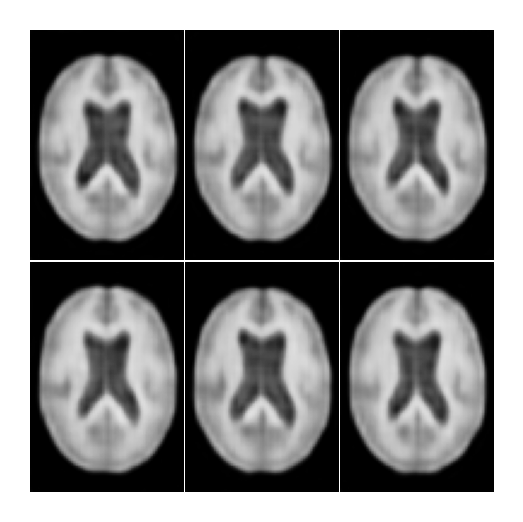

In [16]:
slice = 'axial' # sagittal coronal axial
num_cols = 3
num_rows = 2
num = num_cols * num_rows


for exp in loaded_models.keys():
    print(exp)

    samples = loaded_models[exp].sample(num)
        
    samples = {
        'x': samples[0],
    }
    
    save_name = f'{exp}_uncond_samples'

    fig = plt.figure(figsize=(num_cols, num_rows))
    #gs = fig.add_gridspec(num_rows, num_cols, wspace=-.4, hspace=-.1)

    for i in range(num):
        x = samples['x'][i]
        
        #ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        
        if slice == 'axial':
            gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.6, hspace=0.01)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,:,37], 90), img_cm, vmin=0, vmax=255)
        elif slice == 'sagittal':
            gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.01, hspace=0.01)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,shape[-2]//2,:], 90), img_cm, vmin=0, vmax=255)
        else:
            gs = fig.add_gridspec(num_rows, num_cols, wspace=0.02, hspace=-0.48)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[shape[-3]//2,:,:],90), img_cm, vmin=0, vmax=255)
        
        #ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        ax.axis('off')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
    plt.tight_layout()
    plt.show()

# Conditional Samples

In [17]:
slice = 'sagittal' # sagittal coronal axial

exp = 'ConditionalVISEM'

print(exp)

b_range = [800., 1300., 1800.]
v_range = [10., 100., 1000.]

samples = {
    'x': [],
    'brain_vol': [],
    'ventricle_vol': [],
}

save_name = f'{exp}_cond_samples_{slice}'

num_ex = 3
num_cols = len(b_range)
num_rows = len(v_range)
num = num_ex * num_cols * num_rows

fig = plt.figure(figsize=(num_ex * num_cols * 1.4, num_rows * 1.4))

width_ratios = [0.1 if ((i + 1) % (num_cols + 1)) == 0 else 1 for i in range(num_ex * num_cols + num_ex - 1)]
gs = fig.add_gridspec(num_rows, num_ex * num_cols + num_ex - 1, wspace=.2, hspace=.2, width_ratios=width_ratios)


for _ in range(num_ex):
    z = loaded_models[exp].sample(1)[1]

    for i, brain_vol in enumerate(b_range):
        for j, ventricle_vol in enumerate(v_range):
            brain_vol = torch.tensor([[brain_vol]])
            ventricle_vol = torch.tensor([[ventricle_vol]])
            data = {'z': z, 'brain_vol': brain_vol, 'ventricle_vol': ventricle_vol}

            x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
            samples['x'] += [x]
            samples['brain_vol'] += [brain_vol]
            samples['ventricle_vol'] += [ventricle_vol]


for i in range(num):
    cur_ex = i // (num_cols * num_rows)
    cur_row = (i - cur_ex * num_cols * num_rows) // num_cols
    cur_col = i % num_cols
    
    x = samples['x'][i]

    ax = fig.add_subplot(gs[cur_row, cur_col + cur_ex * (num_cols + 1)])
    
    if slice == 'axial':
        ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,:,shape[-1]//2], 90), img_cm, vmin=0, vmax=255)
    elif slice == 'sagittal':
        ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,shape[-2]//2+10,:], 90), img_cm, vmin=0, vmax=255)
    else:
        ax.imshow(ndimage.rotate(x.numpy().squeeze()[shape[-3]//2,:,:], 90), img_cm, vmin=0, vmax=255)
            
    if cur_col == 0 and cur_ex == 0:
        brain_vol = samples['brain_vol'][i].item()
        ax.set_ylabel('$b={}$'.format(value_fmt['brain_vol'](brain_vol)),
                      fontsize=mpl.rcParams['axes.titlesize'])
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
    if cur_row == 0:
        ventricle_vol = samples['ventricle_vol'][i].item()
        ax.set_title('$v={}$'.format(value_fmt['ventricle_vol'](ventricle_vol)))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

ConditionalVISEM


KeyboardInterrupt: 

<Figure size 3780x1260 with 0 Axes>

# Reconstructions

ConditionalVISEM


FileNotFoundError: [Errno 2] No such file or directory: 'assets/models/lesion_volume/SVIExperiment/ConditionalVISEM/version_13/reconstruction.pt'

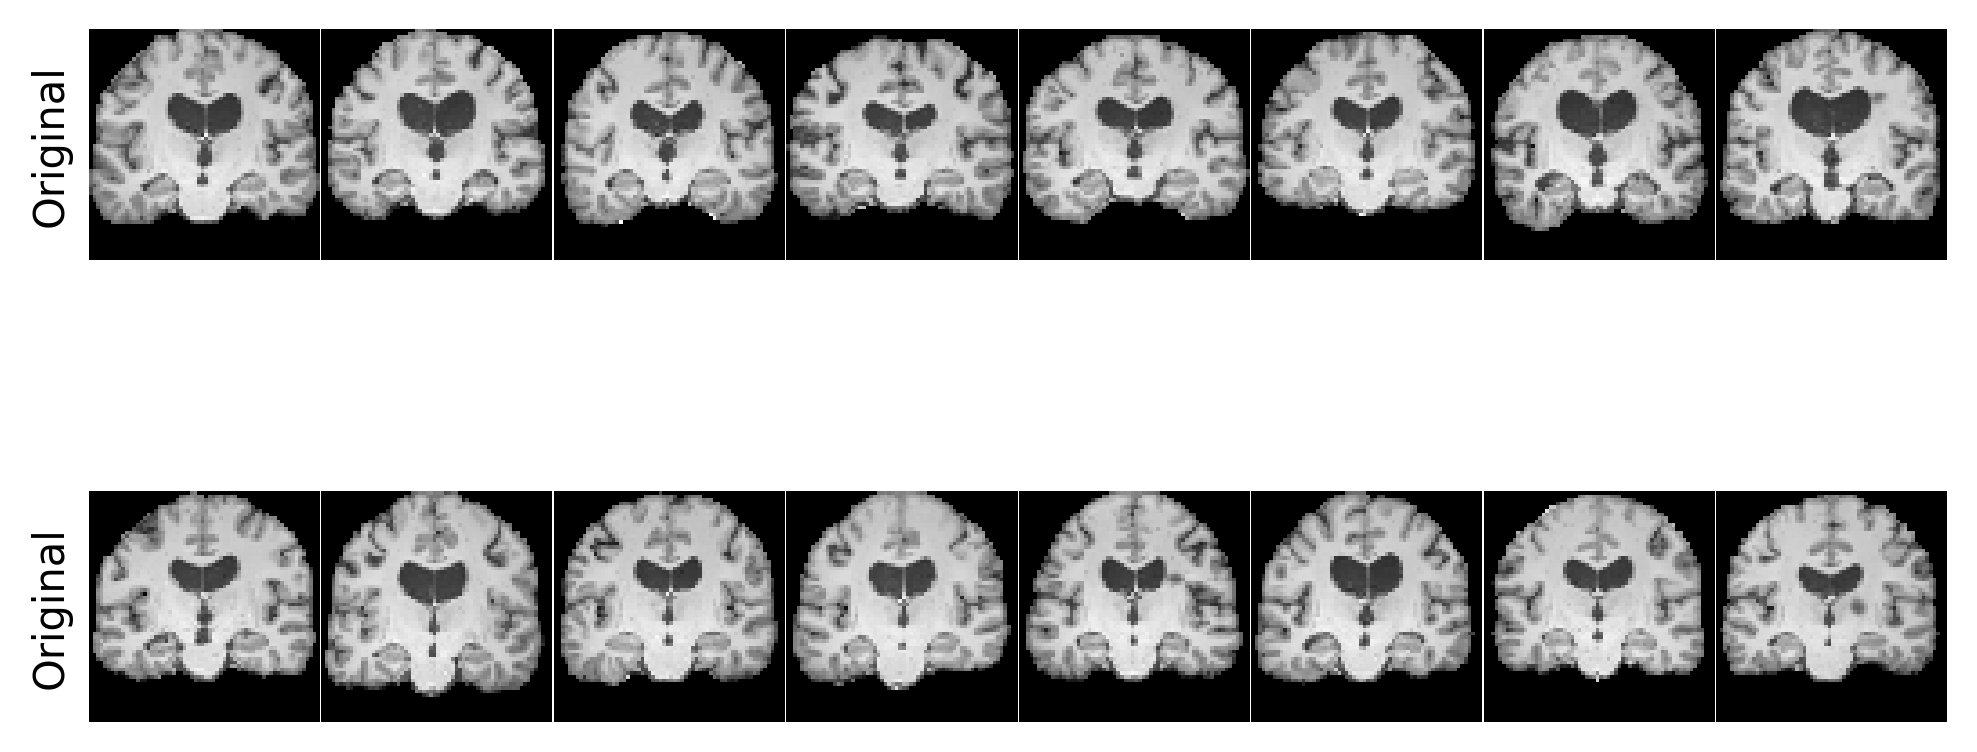

In [27]:
num_samples = 8
num_rows = 2

titles = {
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=0., hspace=0.0)

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples
    
    img = synth_test[i]['image']
    img = ndimage.rotate(img.squeeze(), 180)
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(ndimage.rotate(img[:,48,:], 90), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions['x'][i]
    img = ndimage.rotate(img.squeeze(), 180)

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(ndimage.rotate(img[:,48,:],90), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

ConditionalVISEM


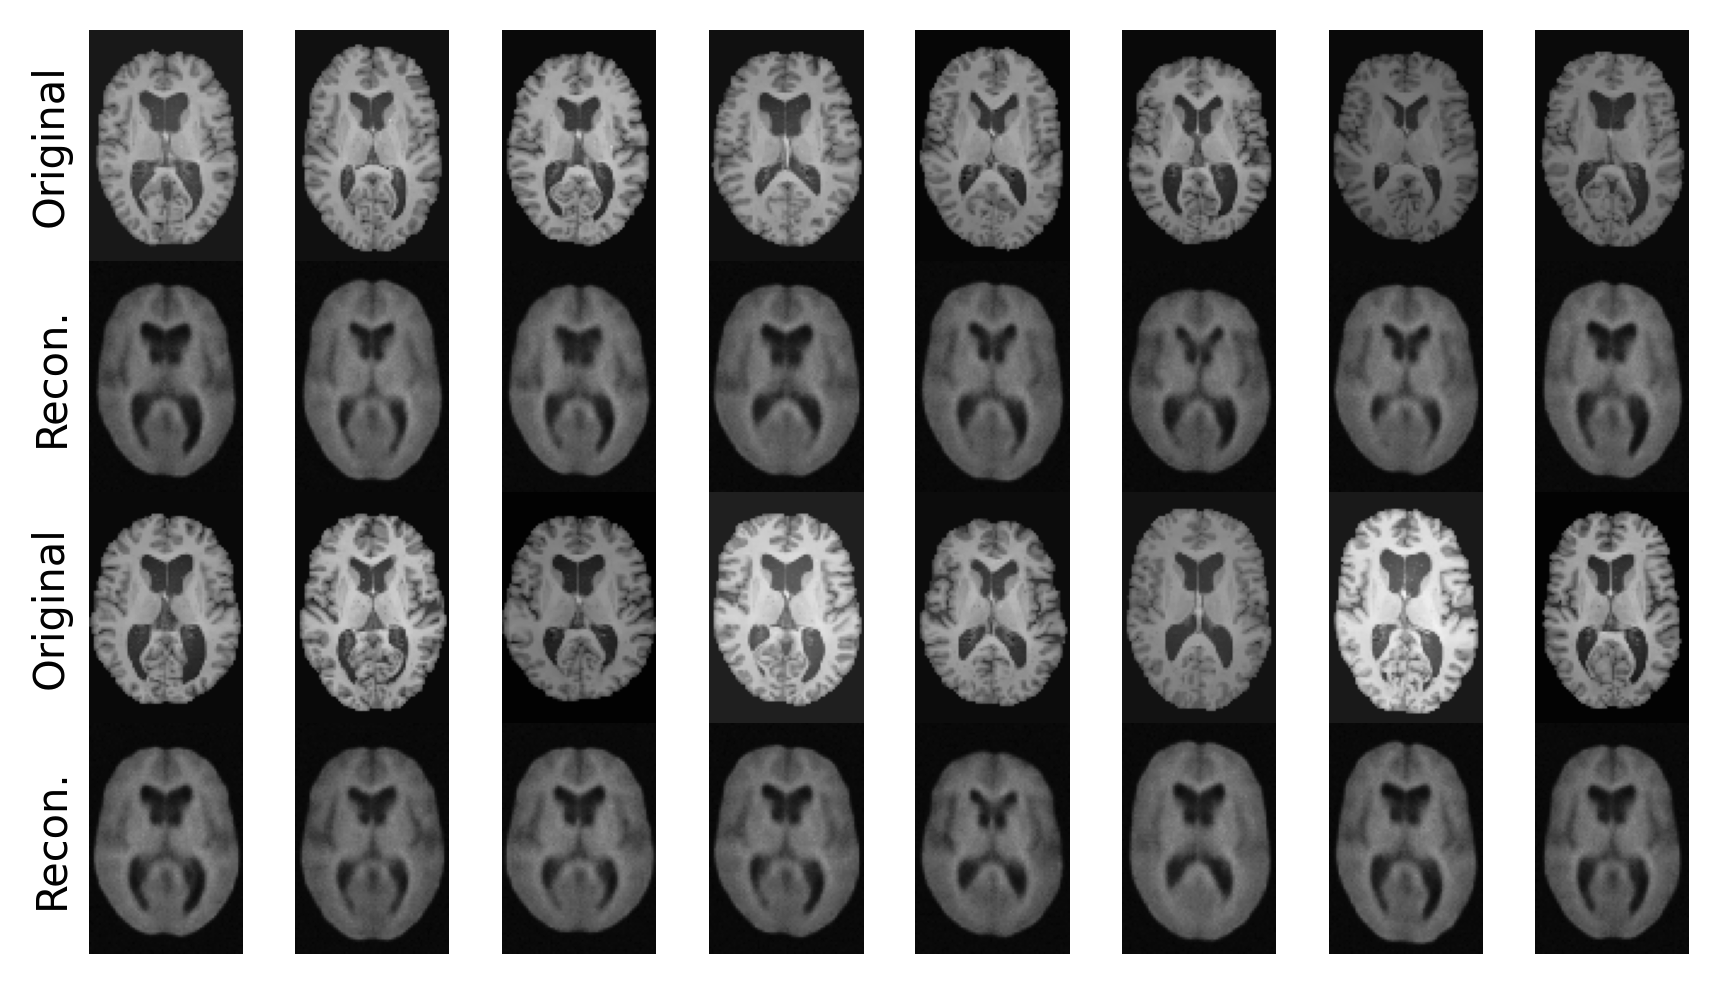

In [38]:
num_samples = 8
num_rows = 2

titles = {
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=-0.5, hspace=0.0)

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples
    
    img = synth_test[i]['image'] * 255
    img = ndimage.rotate(img.squeeze(), 180)
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(ndimage.rotate(img[:,:,32], 270), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions['x'][i]
    img = ndimage.rotate(img.squeeze(), 180)

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(ndimage.rotate(img[:,:,32],270), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

# Age, Brain, Sex KDE

In [39]:
model_name = 'ConditionalVISEM'

def pgm_model(n):
    with pyro.plate('observations', n):
        return loaded_models[model_name].pgm_model()
    
def plot_joint_pdf(x, y, logp, ax=None):
    if ax is None:
        ax = plt.gca()
    prob = logp.exp().numpy().T
    mi = prob.min()
    ma = np.percentile(prob.flat, 99.5)
    step = (ma - mi) / 5
    levels = np.arange(mi, ma, step) + step
    ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, antialiased=True, extend='max')
    
age_range = torch.arange(40, 85, 0.1, dtype=torch.float)
bvol_range = torch.arange(8e2, 18e2, 5e1, dtype=torch.float)
vvol_range = torch.arange(1e1, 1.5e2, 1, dtype=torch.float)

age_range_, bvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, bvol_range)]
age_range_, vvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, vvol_range)]


prob_maps = {'model': {}}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        'ventricle_vol': vvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape),
    }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(age_range_.shape[0])
        trace.compute_log_prob()

    log_prob = trace.nodes['age']['log_prob'] + trace.nodes['brain_volume']['log_prob']
    prob_maps['model'][f"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'brain_vol': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(age_range.shape[0], bvol_range.shape[0])
    }

prob_maps['true'] = {}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    sel = synth_test.subjects['sex'] == sex
    data = torch.stack([torch.tensor(synth_test.subjects['age'][sel].values), torch.tensor(synth_test.subjects['brain_vol'][sel].values)], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([age_range_.flatten(), bvol_range_.flatten()], 0)))
    prob_maps['true'][rf"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], bvol_range.shape[0]))
    }

RuntimeError: shape '[450, 20]' is invalid for input of size 63000

KeyError: 'true'

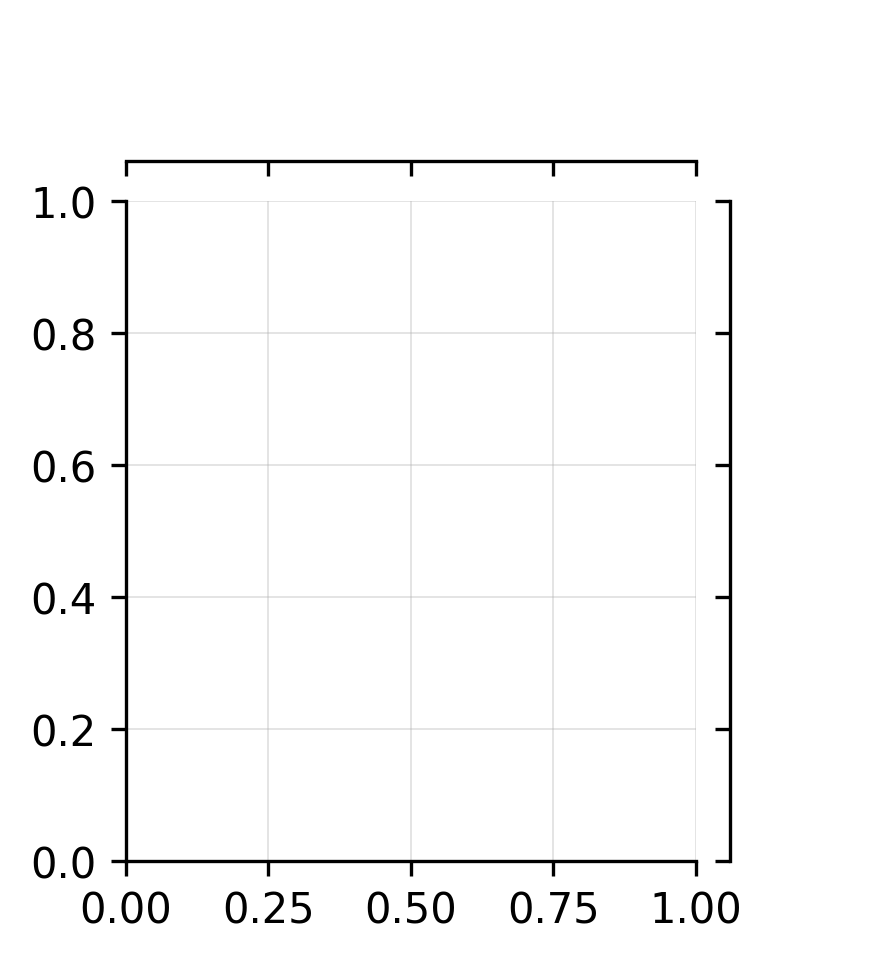

In [40]:
def make_transparent_cmap(cmap):
    n = 256
    colours = cmap(np.linspace(0, 1, n))
    colours[:, -1] = np.linspace(0, 1, n)
    return ListedColormap(colours)    

def plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y):
    contours = []
    for j, (k, v) in enumerate(prob_maps[exp].items()):
        shape = (age_range.shape[0], bvol_range.shape[0])
        age = v['age'].reshape(shape).numpy()
        bvol = v['brain_vol'].reshape(shape).numpy() / 1000
        log_prob = v['log_prob'].reshape(shape).numpy()
        prob = np.exp(log_prob)

        da = age[1, 0] - age[0, 0]
        db = bvol[0, 1] - bvol[0, 0]
        marg_a = prob.sum(1) * da
        marg_b = prob.sum(0) * db * 1000

        mi = prob.min()
        ma = np.percentile(prob.flat, 99.5)
        step = (ma - mi) / 5
        levels = np.arange(mi, ma, step) + step

        filled = False#j == 0
        dashed = j == 1
        cmap = cmaps[j]
        colour = cmap(.7)

        alpha = .8
        if filled:
            ax_joint.contourf(age, bvol, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')
            c = ax_marg_x.fill_between(age[:, 0], marg_a, color=colour, lw=0, alpha=alpha)
            ax_marg_y.fill_betweenx(bvol[0, :], marg_b, color=colour, lw=0, alpha=alpha)
        else:
            kwargs = dict(cmap=cmap.reversed(), antialiased=True, levels=levels, alpha=alpha)
            if dashed:
                kwargs['linestyles'] = 'dashed'
            c = ax_joint.contour(age, bvol, prob, **kwargs)

        kwargs = dict(ls='--') if dashed else {}
        h, = ax_marg_x.plot(age[:, 0], marg_a, c=colour, **kwargs)
        ax_marg_y.plot(marg_b, bvol[0, :], c=colour, **kwargs)

        if filled:
            contours.append(c)
        else:
            contours.append(h)

    ax_marg_x.set_title(titles[exp])
    ax_joint.set_xlabel('Age (years)', fontsize='medium')
    if i == 0:
        ax_joint.set_ylabel('Brain volume (L)', fontsize='medium')
        ax_joint.legend(contours, prob_maps[exp].keys(), fontsize='small')

def plot_all_joints():
    n_exp = len(titles)
    fig = plt.figure(figsize=(6.8, 3.6))
    ratio = 5
    global_gs = fig.add_gridspec(1, n_exp)
    
    ax_joint0 = ax_marg_x0 = ax_marg_y0 = None

    margin = 0.02 / n_exp
    width = 1. / n_exp
    for i, exp in enumerate(titles.keys()):
        gs = global_gs[i].subgridspec(2, 2, width_ratios=[ratio, 1], height_ratios=[1, ratio],
                                   wspace=0.1, hspace=0.1)

        ax_joint = fig.add_subplot(gs[1, 0], sharex=ax_joint0, sharey=ax_joint0)
        ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint0, sharey=ax_marg_x0)
        ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint0, sharex=ax_marg_y0)
        if i == 0:
            ax_joint0 = ax_joint
            ax_marg_x0 = ax_marg_x
            ax_marg_y0 = ax_marg_y
        
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_y.get_yticklabels(), visible=False)
        
        # Turn off the ticks on the density axis for the marginal plots
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_y.get_xticklabels(), visible=False)
        for s in ['top', 'right']:
            ax_joint.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax_marg_x.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax_marg_y.spines[s].set_visible(False)
        ax_marg_x.yaxis.grid(False)
        ax_marg_y.xaxis.grid(False)
        
        if i > 0:
            plt.setp(ax_joint.get_yticklabels(), visible=False)
            
        ax_joint.grid('on', lw=.4, alpha=.4)

        plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y)
    
    fig.tight_layout()

titles = {'true': 'True data', 'model': 'Full model'}
plot_all_joints()
plt.savefig(f'{FIGURE_SAVE_PATH}/ms_age_bvol.png', bbox_inches='tight')

In [22]:
model_name = 'ConditionalVISEM'

def pgm_model(n):
    with pyro.plate('observations', n):
        return loaded_models[model_name].pgm_model()
    
def plot_joint_pdf(x, y, logp, ax=None):
    if ax is None:
        ax = plt.gca()
    prob = logp.exp().numpy().T
    mi = prob.min()
    ma = np.percentile(prob.flat, 99.5)
    step = (ma - mi) / 5
    levels = np.arange(mi, ma, step) + step
    ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, antialiased=True, extend='max')
    
duration_range = torch.arange(1, 85, 0.1, dtype=torch.float)
bvol_range = torch.arange(5e2, 18e2, 5e1, dtype=torch.float)

duration_range_, bvol_range_= [x.reshape(-1, 1) for x in torch.meshgrid(duration_range, bvol_range)]

prob_maps = {'model': {}}
for sex in [0, 1]:
    cond_data = {
        'duration': duration_range_,
        'brain_vol': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(duration_range_.shape),
        'age': torch.tensor(50.0).expand(duration_range_.shape),

    }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(duration_range_.shape[0])
        trace.compute_log_prob()

    log_prob = trace.nodes['duration']['log_prob'] + trace.nodes['brain_vol']['log_prob']
    prob_maps['model'][f"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'duration': trace.nodes['_RETURN']['value'][5],
        'brain_vol': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(duration_range.shape[0], bvol_range.shape[0])
    }

prob_maps['true'] = {}
for sex in [0, 1]:
    cond_data = {
        'duration': duration_range_,
        'brain_vol': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(duration_range_.shape),
        'age': torch.tensor(50.0).expand(duration_range_.shape)
    }

    sel = (synth_test.sex == sex) #& (synth_test.duration > 10)
    data = torch.stack([torch.tensor(synth_test.duration[sel]), torch.tensor(synth_test.brain_vol[sel])], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([duration_range_.flatten(), bvol_range_.flatten()], 0)))
    prob_maps['true'][rf"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'duration': duration_range_,
        'brain_vol': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(duration_range.shape[0], bvol_range.shape[0]))
    }

KeyError: 'duration'

KeyError: 'true'

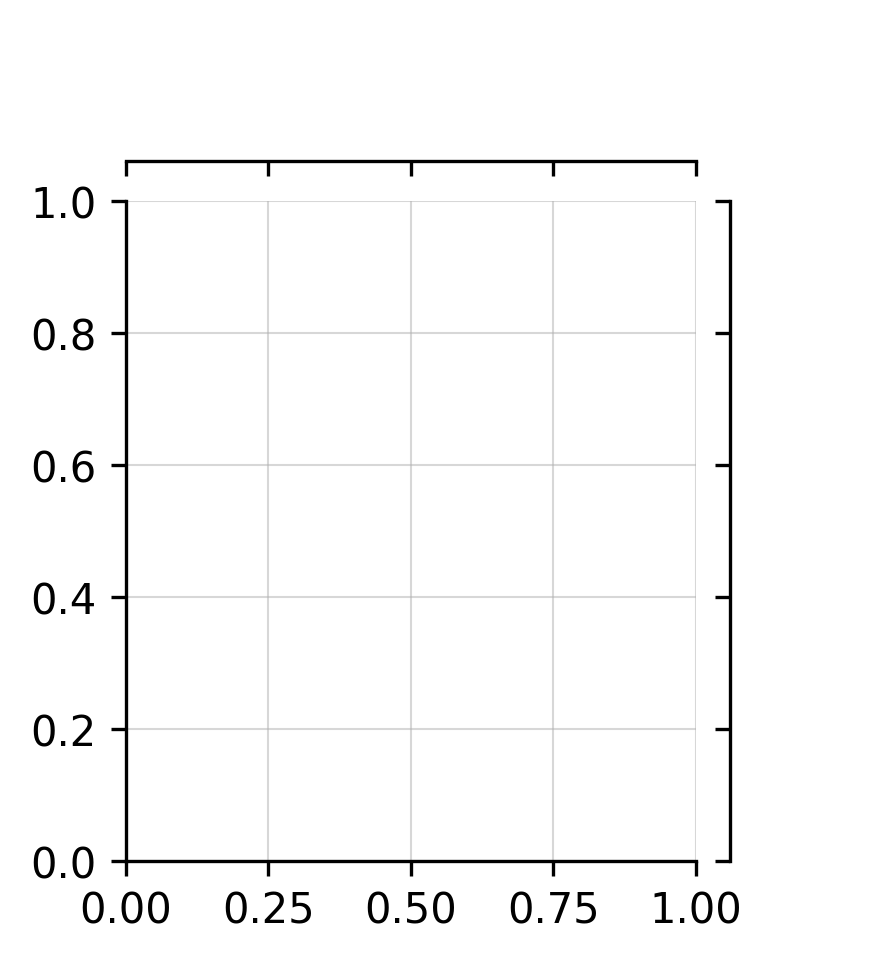

In [ ]:
def make_transparent_cmap(cmap):
    n = 256
    colours = cmap(np.linspace(0, 1, n))
    colours[:, -1] = np.linspace(0, 1, n)
    return ListedColormap(colours)    

def plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y):
    contours = []
    for j, (k, v) in enumerate(prob_maps[exp].items()):
        shape = (duration_range.shape[0], bvol_range.shape[0])
        duration = v['duration'].reshape(shape).numpy()
        bvol = v['brain_vol'].reshape(shape).numpy() / 1000
        log_prob = v['log_prob'].reshape(shape).numpy()
        prob = np.exp(log_prob)

        da = duration[1, 0] - duration[0, 0]
        db = bvol[0, 1] - bvol[0, 0]
        marg_a = prob.sum(1) * da
        marg_b = prob.sum(0) * db * 1000

        mi = prob.min()
        ma = np.percentile(prob.flat, 99.9)
        step = (ma - mi) / 5
        levels = np.arange(mi, ma, step) + step

        filled = False#j == 0
        dashed = j == 1
        cmap = cmaps[j]
        colour = cmap(.7)

        alpha = .8
        if filled:
            ax_joint.contourf(duration, bvol, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')
            c = ax_marg_x.fill_between(duration[:, 0], marg_a, color=colour, lw=0, alpha=alpha)
            ax_marg_y.fill_betweenx(bvol[0, :], marg_b, color=colour, lw=0, alpha=alpha)
        else:
            kwargs = dict(cmap=cmap.reversed(), antialiased=True, levels=levels, alpha=alpha)
            if dashed:
                kwargs['linestyles'] = 'dashed'
            c = ax_joint.contour(duration, bvol, prob, **kwargs)

        kwargs = dict(ls='--') if dashed else {}
        h, = ax_marg_x.plot(duration[:, 0], marg_a, c=colour, **kwargs)
        ax_marg_y.plot(marg_b, bvol[0, :], c=colour, **kwargs)

        if filled:
            contours.append(c)
        else:
            contours.append(h)

    ax_marg_x.set_title(titles[exp])
    ax_joint.set_xlabel('Duration (months)', fontsize='medium')
    if i == 0:
        ax_joint.set_ylabel('Brain volume (L)', fontsize='medium')
        ax_joint.legend(contours, prob_maps[exp].keys(), fontsize='small')

def plot_all_joints():
    n_exp = len(titles)
    fig = plt.figure(figsize=(6.8, 3.6))
    ratio = 5
    global_gs = fig.add_gridspec(1, n_exp)
    
    ax_joint0 = ax_marg_x0 = ax_marg_y0 = None

    margin = 0.02 / n_exp
    width = 1. / n_exp
    for i, exp in enumerate(titles.keys()):
        gs = global_gs[i].subgridspec(2, 2, width_ratios=[ratio, 1], height_ratios=[1, ratio],
                                   wspace=0.1, hspace=0.1)

        ax_joint = fig.add_subplot(gs[1, 0], sharex=ax_joint0, sharey=ax_joint0)
        ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint0, sharey=ax_marg_x0)
        ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint0, sharex=ax_marg_y0)
        if i == 0:
            ax_joint0 = ax_joint
            ax_marg_x0 = ax_marg_x
            ax_marg_y0 = ax_marg_y
        
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_y.get_yticklabels(), visible=False)
        
        # Turn off the ticks on the density axis for the marginal plots
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_y.get_xticklabels(), visible=False)
        for s in ['top', 'right']:
            ax_joint.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax_marg_x.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax_marg_y.spines[s].set_visible(False)
        ax_marg_x.yaxis.grid(False)
        ax_marg_y.xaxis.grid(False)
        
        if i > 0:
            plt.setp(ax_joint.get_yticklabels(), visible=False)
            
        ax_joint.grid('on', lw=.5, alpha=.5)

        plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y)
    
    fig.tight_layout()

titles = {'true': 'True data', 'model': 'Full model'}
plot_all_joints()
plt.savefig(f'{FIGURE_SAVE_PATH}/ms_duration_bvol.png', bbox_inches='tight')

# duration, Brain, lesion KDE

In [ ]:
age_range = torch.arange(20, 80, 0.5, dtype=torch.float)
duration_range = torch.arange(0, 65, 0.5, dtype=torch.float)
bvol_range = torch.arange(800, 16e2, 5, dtype=torch.float)
lvol_range = torch.arange(0, 30, 1, dtype=torch.float)[:-1]
edss_range = torch.arange(0, 6, 0.5, dtype=torch.float)


edss_range_, lvol_range_, age_range_ = torch.meshgrid(edss_range, lvol_range, age_range)

age_bounds = [(20, 30), (30, 40)]

prob_maps = {'model': {}}
for (age_lo, age_hi) in age_bounds:
    sel = (age_range >= age_lo) & (age_range < age_hi)
    cond_data = {
        'edss': edss_range_[:, :, sel].view(-1, 1),
        'lesion_vol': lvol_range_[:, :, sel].view(-1, 1),
        'age': age_range_[:, :, sel].view(-1, 1),
    }

    log_probs = []
    for sex in [0, 1]:
        cond_data['sex'] = torch.full_like(cond_data['edss'], float(sex))

        with torch.no_grad():
            trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(cond_data['edss'].shape[0])
            trace.compute_log_prob()

        log_probs.append(trace.nodes['edss']['log_prob'] + trace.nodes['lesion_vol']['log_prob'])

    sex_prob = torch.sigmoid(loaded_models[model_name].sex_logits)
    log_prob = torch.log(sex_prob * log_probs[0].exp() + (1.-sex_prob) * log_probs[1].exp())
    prob_maps['model'][f"$a\in[{age_lo:g},{age_hi:g})$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'lesion_vol': trace.nodes['_RETURN']['value'][2],
        'edss': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(edss_range_[:, :, sel].shape)
    }
    
prob_maps['true'] = {}
for (age_lo, age_hi) in age_bounds:
    sel = (synth_test.age >= age_lo) & (synth_test.age < age_hi)
    data = torch.stack([torch.tensor(synth_test.edss[sel]), torch.tensor(synth_test.lesion_vol[sel])], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([x.flatten() for x in torch.meshgrid(edss_range, lvol_range)], 0)))
    prob_maps['true'][f"$a\in[{age_lo:g},{age_hi:g})$"] = {
        'edss': edss_range_,
        'lesion_vol': lvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(edss_range.shape[0], lvol_range.shape[0]))
    }

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))

def plot_joint_pdf(x, y, logp, ax, filled=False, **kwargs):
    prob = np.exp(logp.numpy()).T

    valid = np.isfinite(prob)
    mi = prob[valid].min()
    ma = np.percentile(prob[valid].flat, 99.5)
    step = (ma - mi) / 6
    levels = np.arange(mi, ma, step) + step

    if filled:
        ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, extend='max', **kwargs)
    else:
        ax.contour(x, y, prob, cmap=cmaps[0].reversed(), levels=levels, extend='max', **kwargs)
    ax.grid('on', lw=.5, alpha=.5)

for (k, v), ax in zip(prob_maps['true'].items(), axs[0]):
    plot_joint_pdf(edss_range, lvol_range, v['log_prob'], ax, filled=False)
    ax.set_title(k)
    
for (k, v), ax in zip(prob_maps['model'].items(), axs[1]):
    plot_joint_pdf(edss_range, lvol_range, v['log_prob'].logsumexp(-1), ax, filled=False)

for ax in axs[1]:
    ax.set_xlabel("EDSS (score)", fontsize='medium')
for ax in axs[:, 0]:
    ax.set_ylabel("Lesion vol. (ml)", fontsize='medium')
fig.suptitle("True data (top)  /  Full model (bottom)", va='top')

plt.savefig(f'{FIGURE_SAVE_PATH}/medical_edss_lvol.png', bbox_inches='tight')

# duration, lesion_volume, EDSS KDE

In [ ]:
duration_range = torch.arange(0, 65, 0.5, dtype=torch.float)
bvol_range = torch.arange(800, 18e2, 5, dtype=torch.float)
lvol_range = torch.arange(0, 30, 1, dtype=torch.float)[:-1]
edss_range = torch.arange(0, 10, 0.5, dtype=torch.float)[:-1]
age_range = torch.arange(0, 65, 0.5, dtype=torch.float)


duration_range_, bvol_range_, age_range_ = torch.meshgrid(duration_range, bvol_range, age_range)

age_bounds = [(30, 35), (50, 55)]

prob_maps = {'model': {}}
for (age_lo, age_hi) in age_bounds:
    sel = (age_range >= age_lo) & (age_range < age_hi)
    cond_data = {
        'duration': duration_range_[:, :, sel].view(-1, 1),
        'brain_vol': bvol_range_[:, :, sel].view(-1, 1),
        'age': age_range_[:, :, sel].view(-1, 1),
    }

    log_probs = []
    for sex in [0, 1]:
        cond_data['sex'] = torch.full_like(cond_data['duration'], float(sex))

        with torch.no_grad():
            trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(cond_data['duration'].shape[0])
            trace.compute_log_prob()

        log_probs.append(trace.nodes['duration']['log_prob'] + trace.nodes['brain_vol']['log_prob'])

    sex_prob = torch.sigmoid(loaded_models[model_name].sex_logits)
    log_prob = torch.log(sex_prob * log_probs[0].exp() + (1.-sex_prob) * log_probs[1].exp())
    prob_maps['model'][f"$e\in[{age_lo:g},{age_hi:g})$"] = {
        'duration': trace.nodes['_RETURN']['value'][2],
        'brain_vol': trace.nodes['_RETURN']['value'][3],
        'age': trace.nodes['_RETURN']['value'][0],
        'log_prob': log_prob.reshape(duration_range_[:, :, sel].shape)
    }
    
prob_maps['true'] = {}
for (age_lo, age_hi) in age_bounds:
    sel = (synth_test.age >= age_lo) & (synth_test.age < age_hi)
    data = torch.stack([torch.tensor(synth_test.duration[sel]), torch.tensor(synth_test.brain_vol[sel])], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([x.flatten() for x in torch.meshgrid(duration_range, bvol_range)], 0)))
    prob_maps['true'][f"$a\in[{age_lo:g},{age_hi:g})$"] = {
        'duration': duration_range_,
        'brain_vol': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(duration_range.shape[0], bvol_range.shape[0]))
    }

In [ ]:
trace.nodes['_RETURN']['value'][5]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))

for (k, v), ax in zip(prob_maps['true'].items(), axs[0]):
    plot_joint_pdf(duration_range, bvol_range, v['log_prob'], ax, filled=False)
    ax.set_title(k)
    
for (k, v), ax in zip(prob_maps['model'].items(), axs[1]):
    plot_joint_pdf(duration_range, bvol_range, v['log_prob'].logsumexp(-1), ax, filled=False)

for ax in axs[1]:
    ax.set_xlabel("Duration (months)", fontsize='medium')
for ax in axs[:, 0]:
    ax.set_ylabel("Brain vol. (ml)", fontsize='medium')
fig.suptitle("True data (top)  /  Full model (bottom)", va='top')

plt.savefig(f'{FIGURE_SAVE_PATH}/medical_duration_bvol_age.png', bbox_inches='tight')

# Counterfactuals

In [47]:
def plot_intervention_range(bp, interventions, idx, normalise_all=True):
    fig, ax = plt.subplots(2, len(interventions) + 1, figsize=(1.6 * len(interventions), 2), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0
    
    imgs = []
    for intervention in interventions:
        f = os.path.join(bp, f'{intervention}.pt')
        samples = torch.load(f)

        main_intervention = intervention[3:].split('=')[0]

        imgs += [samples['x'][idx]]
        
        x_test = (synth_test[idx]['image'] * 255.)
        diff = (x_test - imgs[-1].numpy()).squeeze()

        lim = np.maximum(lim, np.absolute(diff).max())

    for i, intervention in enumerate(interventions):
        
        main_intervention = intervention[3:].split('=')[0]
        
        val = synth_test[idx][main_intervention]

        v_name = var_name[main_intervention]
        v_val = value_fmt[main_intervention](val)
        i_val = value_fmt[main_intervention](float(intervention[3:-1].split('=')[1]))
        
        x = imgs[i]
        x_test = (synth_test[idx]['image'] * 255.)
        diff = (x_test[:,:,48,:] - x[:,:,48,:].numpy()).squeeze()
        if not normalise_all:
            lim = np.absolute(diff).max()


        ax[0, i+1].set_title(f"$do({v_name}={i_val})$", fontsize=6)
        
        x = ndimage.rotate(x.squeeze()[:,48,:], 90)
        ax[0, i+1].imshow(x, 'Greys_r')
        
        diff = ndimage.rotate(diff, 90)
        ax[1, i+1].imshow(diff, 'seismic', clim=[-100, 100])

    for i in range(len(interventions)+1):
        for axi in ax[:, i]:
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())

    #x_test = ndimage.rotate(x_test.squeeze(), 180)
    ax[0, 0].imshow(ndimage.rotate(x_test.squeeze()[:,48,:], 90), 'Greys_r')
    ax[0, 0].set_title('Original', fontsize=6)
    #ax[0, 0].axis('off')
    #ax[0, 0].xaxis.set_major_locator(plt.NullLocator())
    #ax[0, 0].yaxis.set_major_locator(plt.NullLocator())
    
    # suptitle = '$s={sex}; a={age}; b={brain_vol}; v={ventricle_vol}$'.format(
    #     **{att: value_fmt[att](synth_test.subjects[idx][att]) for att in ('sex', 'age', 'brain_volume', 'ventricle_volume')}
    # )
    # fig.suptitle(suptitle, fontsize=6, y=1.04)
    

    #fig.tight_layout()

    plt.savefig(f"{FIGURE_SAVE_PATH}/intervention_range_{idx}_normalised_{normalise_all}_{np.random.randint(1,50)}.png", bbox_inches='tight', pad_inches=0)
    plt.show()

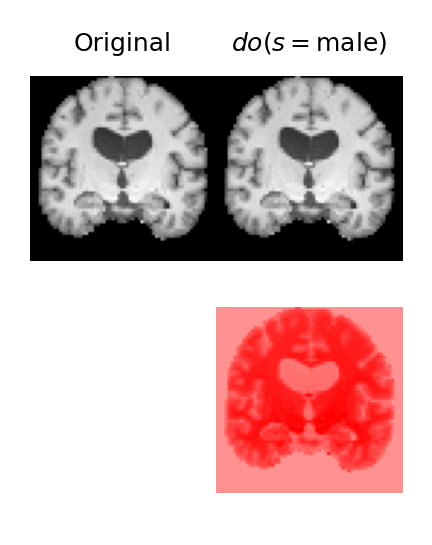

In [48]:
wanted_dos = ['do(sex=1)']
for idx in [0]:
    bp = f'{BASE_LOG_PATH}/ConditionalVISEM/version_{version}/'
    plot_intervention_range(bp, wanted_dos, idx, True)

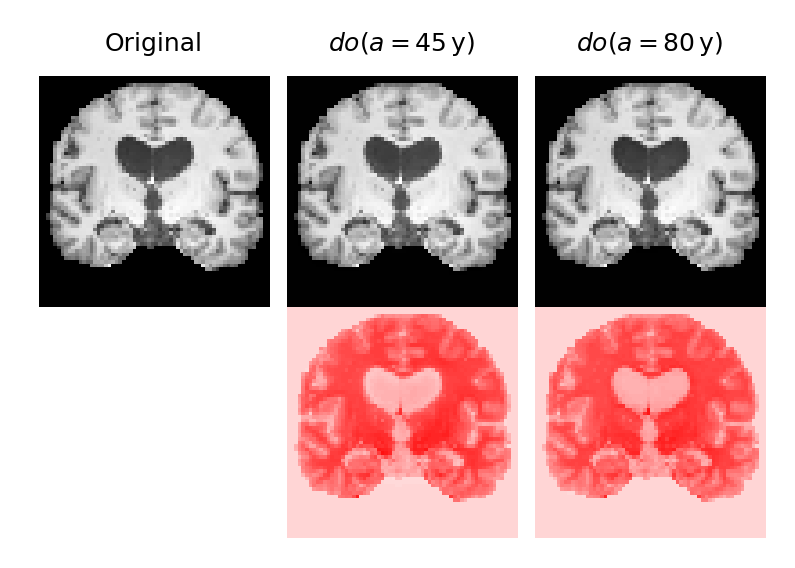

In [49]:
wanted_dos = ['do(age=45)', 'do(age=80)']
for idx in [5]:
    bp = f'{BASE_LOG_PATH}/ConditionalVISEM/version_{version}/'
    plot_intervention_range(bp, wanted_dos, idx, True)

In [ ]:
wanted_dos = ['do(brain_vol=1000)', 'do(brain_vol=1200)', 'do(brain_vol=1400)']
for idx in [1,10,20,40,80,89,90]:
    bp = f'{BASE_LOG_PATH}/ConditionalVISEM/version_{version}/'
    plot_intervention_range(bp, wanted_dos, idx, True)

In [ ]:
wanted_dos = ['do(duration=10)', 'do(duration=20)', 'do(duration=60)']
for idx in [55,60,70,90,100]:
    bp = f'{BASE_LOG_PATH}/ConditionalVISEM/version_{version}/'
    plot_intervention_range(bp, wanted_dos, idx, True)

# Counterfactual Traversals

In [ ]:
def plot_gen_intervention_range(model_name, all_interventions, save_name, normalise_all=True, num_samples=32):
    
    
    num_idx = len(all_interventions)
    num_inter = len(all_interventions[0][1])
    
    hrs = [0.2 if ((i + 1) % 3) == 0 else 1 for i in range(2 * num_idx + num_idx - 1)]
    fig, ax = plt.subplots(2 * num_idx + num_idx - 1, (num_inter + 1), figsize=(1.8 * (num_inter + 1), 4*num_idx),
                           gridspec_kw=dict(wspace=0, hspace=0, height_ratios=hrs))
    lim = 0
    
    for cur_ex, (idx, interventions) in enumerate(all_interventions):
        orig_data = prep_data(synth_test[idx])

        imgs = []
        for intervention in interventions:
            pyro.clear_param_store()
            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

            imgs += [counterfactual['x']]

            diff = (orig_data['x'] - imgs[-1]).squeeze()

            lim = np.maximum(lim, diff.abs().max())
            
        x_test = orig_data['x']
        ax[cur_ex * 3, 0].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        ax[cur_ex * 3, 0].set_title('Original')

        for i, intervention in enumerate(interventions):
            x = imgs[i]
            
            diff = (x_test - x).squeeze()
            if not normalise_all:
                lim = diff.abs().max()

            ax[cur_ex * 3, i + 1].set_title(fmt_intervention(intervention))
            ax[cur_ex * 3, i + 1].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

            ax[cur_ex * 3 + 1, i + 1].imshow(diff, 'seismic', clim=[-lim, lim])
        
        att_str = '$s={sex}$\n$a={age}$\n$b={brain_vol}$\n$l={lesion_vol}$'.format(
            **{att: value_fmt[att](orig_data[att].item()) for att in ('sex', 'age', 'brain_vol', 'lesion_vol')}
        )
        
        ax[cur_ex * 3 + 1, 0].text(0.5, 0.5, att_str, horizontalalignment='center',
                                   verticalalignment='center', transform=ax[cur_ex * 3 + 1, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
        
    for axi in ax.ravel():
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    #plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
        
    plt.show()

In [ ]:
idx = [10, 20]
model_name = 'ConditionalVISEM'

orig_data = prep_data(synth_test[idx])

interventions = [
    (10, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (13, [
        {'sex': 0.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 10.},
        {'lesion_vol': 15.},
    ]),
    (42, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (1, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (100, [
        {'sex': 0.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 10.},
        {'lesion_vol': 15.},
    ]),
]

save_name = 'counterfactual_range'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)
